In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
from scipy.linalg import lu_factor,lu_solve
from scipy.stats import multivariate_normal as mn
def colors(n): 
    if n<4: return [[1,0,0],[0,0,1],[0,1,0]]
    ret = [] 
    r = int(random.random() * 256) 
    g = int(random.random() * 256) 
    b = int(random.random() * 256)
    for i in range(n):
        r = int(r/(n+1))/255
        g = int(g/(n+1))/255
        b = int(b/(n+1))/255
        ret.append((r,g,b))  
    return ret 

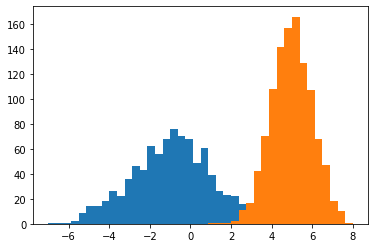

In [2]:
m1,m2 = -1,5
v1,v2 = 2,1
s1 = np.random.normal(m1,v1,900)
s2 = np.random.normal(m2,v2,1100)
c1,b1,i1 = plt.hist(s1,40,range=[-7,8])
c2,b2,i2 = plt.hist(s2,40,range=[-7,8])

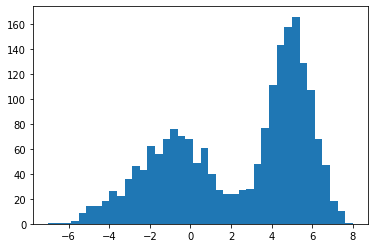

In [3]:
data = np.concatenate((s1,s2))
c,b,i = plt.hist(data,40,range=[-7,8])
# for j in range(20): i[j].set_facecolor('r')

### Clustering 1D samples
Expectation Maximisation (EM) Algorithm
1. E-step assigns responsibility that component k takes datapoint n.
$$\begin{align*} q(s_n=k)&=r_{nk}=\frac{u_{nk}}{u_n} \\ 
u_{nk}&=\frac{\pi_k}{\sqrt{2\pi\sigma^2_k}}e^{-\frac{1}{2\sigma_k^2} (x_n-\mu_k)^2} \\ u_n &= \sum^K_{k=1}u_{nk} \end{align*} 
$$
2. M-step performs supervised learning with known (soft) cluster assignments.
$$\begin{align*}
\mu_j &= \frac{\sum^N_{n=1}q(s_n=j)x_n}{\sum^N_{n=1}q(s_n=j)} \\
\sigma^2_j &= \frac{\sum^N_{n=1}q(s_n=j)(x_n-\mu_j)^2}{\sum^N_{n=1}q(s_n=j)} \\
\pi_j &= \frac{1}{N}\sum^N_{n=1}q(s_n=j)
\end{align*}
$$
3. Free Energy
$$
\mathcal{F}(q(s),\theta)=\sum^N_{n=1}\sum^K_{k=1}q(s_{n=k})\bigg(\log\pi_k - \frac{1}{2\sigma^2_k}(x_n-\mu_k)^2-\frac{1}{2}\log \sigma^2_k \bigg)
$$

In [4]:
def e_step(data,m,v,p):
    u_nk = p/np.sqrt(2*np.pi*v)*\
        np.exp(-(data[:,np.newaxis]-m.reshape(1,-1))**2/v/2)
    u_n = np.sum(u_nk,axis=1)
    q_nk = u_nk/u_n.reshape(-1,1)
#     print(q_nk.shape)
    return q_nk
def m_step(q_nk,data,L):
    q_k = np.sum(q_nk,axis=0)
#     print(q_nk.shape,q_k.shape)
#     print(sum(q_k))
    m = np.sum(q_nk*data.reshape(-1,1),axis=0)/q_k
#     print(m.shape)
    v = np.sum(q_nk*(data.reshape(-1,1)-m)**2,axis=0)/q_k
    p = q_k/L
    return m,v,p
def fenergy(q_nk,data,m,v,p):
    return np.sum(q_nk*(np.log(p)-0.5*np.log(v)-\
      (data[:,np.newaxis]-m.reshape(1,-1))**2/v/2))
def gmm_1d(data,k=2,iters=10,seed=None):
    if seed!=None:
        random.seed(seed)
    L = len(data)
    mi,ma = np.min(data),np.max(data)
    m = np.random.uniform(mi,ma,k)
#     m = np.array([-10,10])
    v = np.random.uniform(0,2,k)
    p = np.random.uniform(0,1,k)
    p /= sum(p)
    res = []
    for i in range(iters):
        q_nk = e_step(data,m,v,p)
        fen = fenergy(q_nk,data,m,v,p)
        res.append(fen)
        m,v,p = m_step(q_nk,data,L)
    q_nk = e_step(data,m,v,p)
    s = np.argmax(q_nk,axis=1)
    cs = colors(k)
    plt.figure(figsize=(20,20))
    plt.subplot(2,1,1)
    for j in np.unique(s):
        plt.hist(data[s==j],40,range=[mi,ma],color=cs[j])
        plt.axvline(x=m[j],color='k')
    plt.subplot(2,1,2)
    plt.plot(range(iters),res)

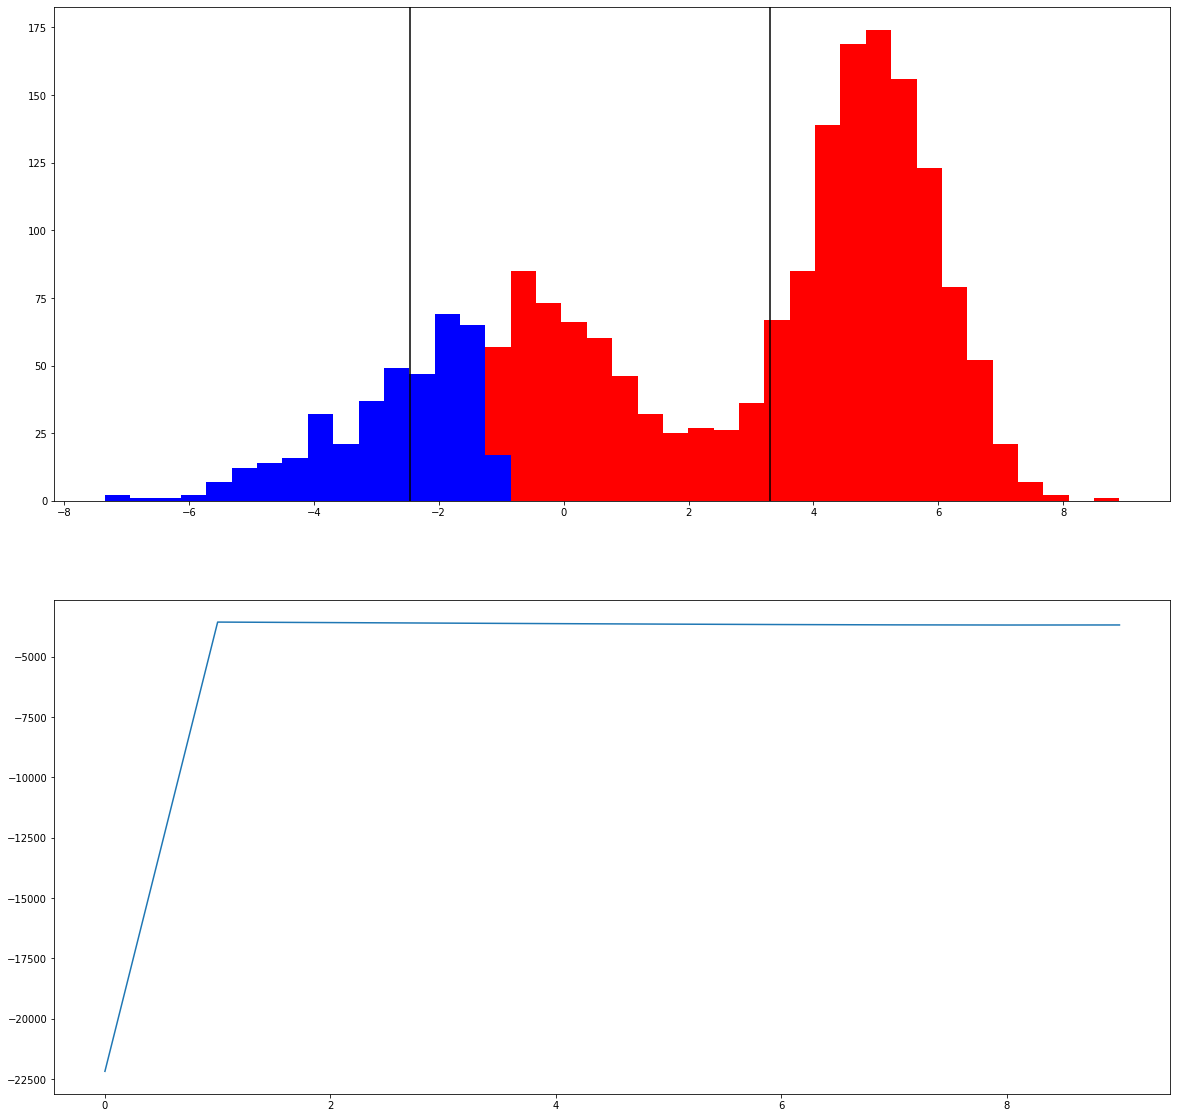

In [5]:
gmm_1d(data,seed=1)